# **Курсовой проект по вычислительной математике**

# 1. Постановка задачи
Сравнить численные решения, полученные по разностным схемам Лакса, Куранта–Изаксона–Риса, Лакса–Вендроффа, Уорминга–Кутлера–Ломакса для уравнения переноса в недивергентной и дивергентной формах:
$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0 $$
$$ \frac{\partial u}{\partial t} + \frac{\partial}{\partial x} \left( \frac{u^2}{2}\right) = 0 $$

Начальные профили:

![](images/profiles.png)

# 2. Точое решение

## 2.1 Прямоугольный профиль
Точное решение для уравнения Хопфа
$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0 $$
с начальным условием вида 

$$ 
u(x, t) = 
\begin{cases}
1, &  a \le x \le b, \\
0, & x < a \cup x > b
\end{cases} 
$$

можно найти с помощью метода характеристик. Будем рассматривать случай, когда конечное время $ t \le 2(b-a)$. Тогда точное решение имеет вид:

$$ 
u(x, t) = 
\begin{cases}
0, &  x < a \\
\frac{x-a}{t}, & a \le x \le a + t \\
1, & a + t \le x \le b + \frac{t}{2} \\
0, & x > b + \frac{t}{2}
\end{cases} 
$$



Функция точного решения:

In [241]:
def accurate_solution_rectangle(x_list, a, b, t_end):
    if (t_end > 2 * (b - a)):
        print (t_end, 2 * (b-a))
        raise Exception("Конечное время должно быть не больше, чем 2*(b-a)")
    
    u = []

    for x in x_list:
        if (x < a):
            u.append(0)
        elif (a <= x and x <= a + t_end):
            u.append((x - a) / t_end)
        elif (a + t_end <= x and x < b + t_end / 2):
            u.append(1)
        elif (x >= b + t_end / 2):
            u.append(0)
        
    return u

Функция для сравнения точного решения и численного решения:

In [242]:
def find_difference(u_1, u_2):
    if len(u_1) != len (u_2):
        raise Exception
    return [abs(a - b) for a, b in zip(u_1, u_2)]

# 3. Начальные профили


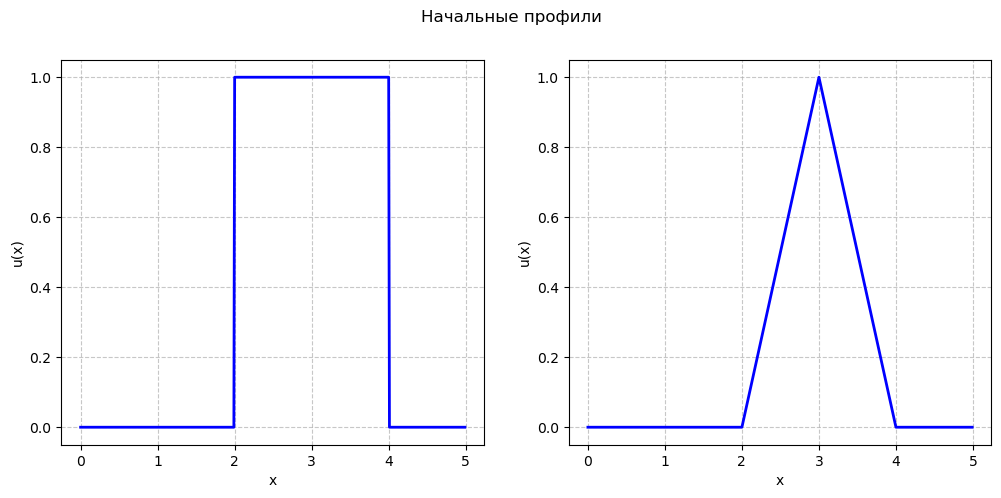

In [243]:
import numpy as np
import matplotlib.pyplot as plt

# Прямоугольник
def rectangle(x, height, L):
    if (L/2 <= x and x <= L):
        return height
    else:
        return 0

# Треугольник
def triangle(x, height, L):
    if (L/ 2 <= x and x <= 3*L/4):
        return x * height * 4/L - 2*height
    if(3*L/4 <= x and x <= L):
        return -x * height * 4/L + 4*height
    else:
        return 0

# Функция для построения графиков
def plot_start_profiles(x, y1, y2, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(x, y1, color='blue', linewidth=2)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_xlabel("x")
    ax1.set_ylabel("u(x)")
    

    ax2.plot(x, y2, color='blue', linewidth=2)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.set_xlabel("x")
    ax2.set_ylabel("u(x)")

    fig.suptitle(title)

    plt.show()

# Создание данных для начальных профилей
def start_profiles():
    x = np.arange(0, 5, 0.01)
    height = 1
    L = 4
    y_rect = []
    for i in x:
        y_rect.append(rectangle(i, height, L))
    y_triang = []
    for i in x:
        y_triang.append(triangle(i, height, L))
    
    return x, y_rect, y_triang

x, y_rect, y_triang = start_profiles()
plot_start_profiles(x, y_rect, y_triang, "Начальные профили")

# 4. Исследование прямоугольного профиля

## 4.1 Cхема Лакса

Схема Лакса имеет следующий шаблон:

![](images/lax_template.png)

Разностное уравнение, соответствующее недивергентному уравнению переноса:
$$\frac{u^{n+1}_{m} - 0.5\left( u^{n}_{m+1} + u^{n}_{m-1}\right)}{\tau} + u^{n}_{m} \frac{u^n_{m+1} - u^n_{m-1}}{2h} = 0$$

Разностное уравнение, соответствующее дивергентному уравнению переноса:
$$\frac{u^{n+1}_{m} - 0.5\left( u^{n}_{m+1} + u^{n}_{m-1}\right)}{\tau} + \frac{\left( u^n_{m+1} \right)^2 - \left(u^n_{m-1}\right)^2}{2 \cdot 2h} = 0$$

Порядок аппроксимации: $ O\left( \tau + h^2 + \frac{h^2}{\tau}\right)$

Схема является условно устойчивой: $$ \frac{\tau}{h} \cdot \max_{m}|u^{n}_{m}| \le 1 $$

Начальные условия:

In [244]:
x_start = 0
x_end = 10
t_start = 0
t_end = 1
h = 0.001

height = 1
L = 4

Реализация схемы Лакса для недивергентного уравнения переноса

In [245]:
def Lax_ndivergent(u_0, x_start, x_end, t_start, t_end, h):
    x = np.arange(x_start, x_end + h, h)
    u = []
    for i in x:
        u.append(u_0(i, height, L))

    u_new = u.copy()
    t_cur = t_start
    CFL = 0.9
    u_max = max(abs(elem) for elem in u)
    tau =  CFL * h / u_max

    while t_cur < t_end:
        # Определяем шаг по времени tau на основе условия Куранта
        u_max = max(abs(elem) for elem in u)
        while (tau * u_max / h > 1): 
            tau *= CFL

        for i in range(1, len(x) - 1):
            u_new[i] = 0.5 * (u[i+1] + u[i-1]) - (tau / (2 * h)) * u[i] * (u[i+1] - u[i-1])

        t_cur += tau
        u = u_new.copy()
    return x, u

Реализация схемы Лакса для дивергентного уравнения переноса

In [246]:
def Lax_divergent(u_0, x_start, x_end, t_start, t_end, h):
    x = np.arange(x_start, x_end + h, h)
    u = []
    for i in x:
        u.append(u_0(i, height, L))

    u_new = u.copy()
    t_cur = t_start
    CFL = 0.9
    u_max = max(abs(elem) for elem in u)
    tau =  CFL * h / u_max

    while t_cur < t_end:
        # Определяем шаг по времени tau на основе условия Куранта
        u_max = max(abs(elem) for elem in u)
        while (tau * u_max / h > 1): 
            tau *= CFL

        for i in range(1, len(x) - 1):
            u_new[i] = 0.5 * (u[i+1] + u[i-1]) - (tau / (4 * h)) * ((u[i+1])**2 - (u[i-1])**2)

        t_cur += tau
        u = u_new.copy()

    return x, u

Строим графики:

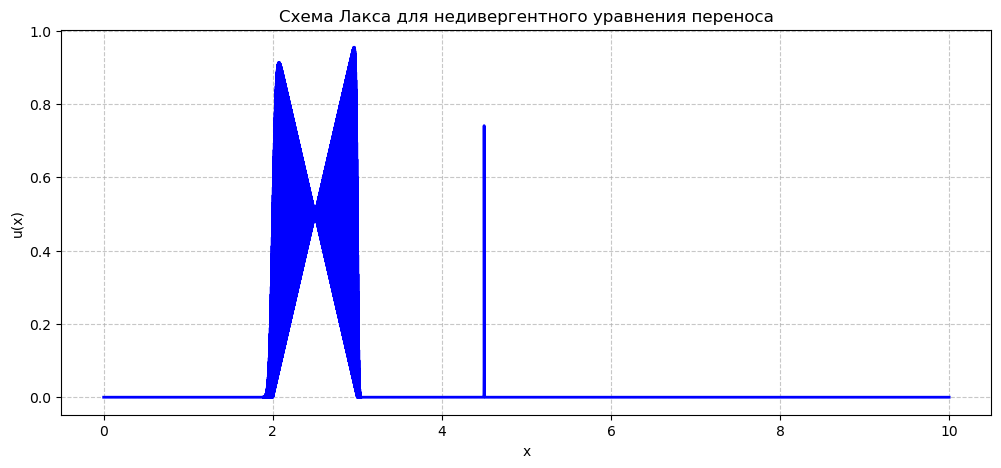

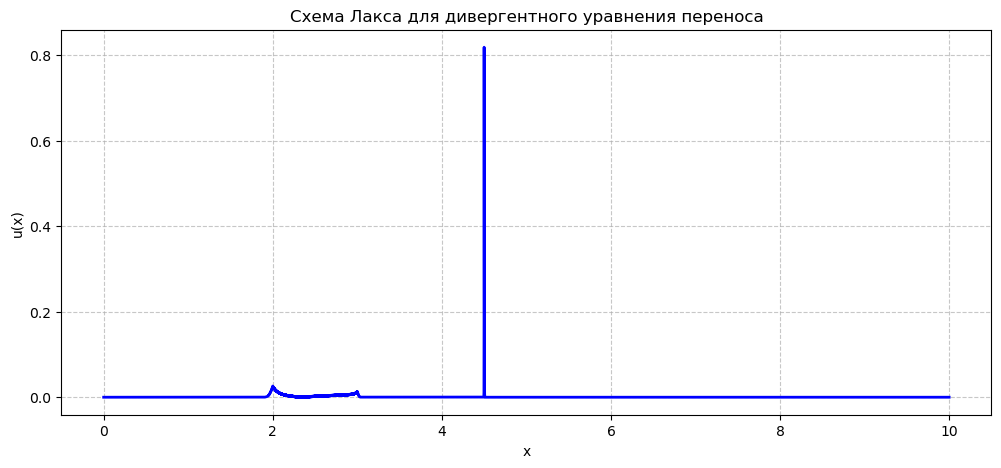

In [247]:
def plot_graph(x, y, title):
    plt.figure(figsize=(12, 5))
    plt.plot(x, y, color='blue', linewidth=2)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("u(x)")
    
    plt.show()


def plot_difference(x_list, u_num, u_acc, title):
    u = []
    for a, b in zip(u_num, u_acc):
        u.append(abs(a - b))
    
    plot_graph(x_list, u, title)
    

x_Lax_ndivergent, u_Lax_ndivergent = Lax_ndivergent(rectangle, x_start, x_end, t_start, t_end, h)
plot_difference(x_Lax_ndivergent, u_Lax_ndivergent, accurate_solution_rectangle(x_Lax_ndivergent, L/2, L, t_end), "Схема Лакса для недивергентного уравнения переноса")

x_Lax_divergent, u_Lax_divergent = Lax_divergent(rectangle, x_start, x_end, t_start, t_end, h)
plot_difference(x_Lax_divergent, u_Lax_divergent, accurate_solution_rectangle(x_Lax_divergent, L/2, L, t_end), "Схема Лакса для дивергентного уравнения переноса")


## 4.2 Cхема Куранта-Изаксона-Риса (КИР)

Схема КИР имеет следующий шаблон:

<img src="images/CIR_template.png" width="1000" />

Разностное уравнение, соответствующее недивергентному уравнению переноса:
$$\frac{u^{n+1}_{m} - u^{n}_{m}}{\tau} + u^{n}_{m} \frac{u^n_{m} - u^n_{m-1}}{h} = 0,\text{ при } u^{n}_{m} > 0 $$

$$\frac{u^{n+1}_{m} - u^{n}_{m}}{\tau} + u^{n}_{m} \frac{u^n_{m+1} - u^n_{m}}{h} = 0,\text{ при } u^{n}_{m} < 0 $$

Разностное уравнение, соответствующее дивергентному уравнению переноса:

$$\frac{u^{n+1}_{m} - u^{n}_{m}}{\tau} + \frac{\left(u^n_{m}\right)^2 - \left(u^n_{m - 1}\right)^2}{2 \cdot h} = 0,\text{ при } u^{n}_{m} > 0 $$

$$\frac{u^{n+1}_{m} - u^{n}_{m}}{\tau} + \frac{\left(u^n_{m+1}\right)^2 - \left(u^n_{m}\right)^2}{2 \cdot h} = 0,\text{ при } u^{n}_{m} < 0 $$

Порядок аппроксимации: $ O\left( \tau + h\right)$

Схема является условно устойчивой: $$ \frac{\tau}{h} \cdot \max_{m}|u^{n}_{m}| \le 1 $$


Реализация схемы КИР для недивергентного уравнения переноса:

In [248]:
def CIR_ndivergent(u_0, x_start, x_end, t_start, t_end, h):
    x = np.arange(x_start, x_end + h, h)
    u = []
    for i in x:
        u.append(u_0(i, height, L))

    u_new = u.copy()
    t_cur = t_start
    CFL = 0.9
    u_max = max(abs(elem) for elem in u)
    tau =  CFL * h / u_max

    while t_cur < t_end:
        # Определяем шаг по времени tau на основе условия Куранта
        u_max = max(abs(elem) for elem in u)
        while (tau * u_max / h > 1): 
            tau *= CFL

        for i in range(1, len(x) - 1):
            if u[i] >= 0:
                u_new[i] = u[i] - (tau / h) * u[i] * (u[i] - u[i-1])
            else:
                u_new[i] = u[i] - (tau / h) * u[i] * (u[i+1] - u[i])

        t_cur += tau
        u = u_new.copy()
    return x, u

Реализация схемы КИР для дивергентного уравнения переноса:

In [249]:
def CIR_divergent(u_0, x_start, x_end, t_start, t_end, h):
    x = np.arange(x_start, x_end + h, h)
    u = []
    for i in x:
        u.append(u_0(i, height, L))

    u_new = u.copy()
    t_cur = t_start
    CFL = 0.9
    u_max = max(abs(elem) for elem in u)
    tau =  CFL * h / u_max

    while t_cur < t_end:
        # Определяем шаг по времени tau на основе условия Куранта
        u_max = max(abs(elem) for elem in u)
        while (tau * u_max / h > 1): 
            tau *= CFL
        for i in range(1, len(x) - 1):
            if u[i] >= 0:
                u_new[i] = u[i] - (tau / (2*h)) * ((u[i])**2 - (u[i-1])**2)
            else:
                u_new[i] = u[i] - (tau / (2*h)) * ((u[i+1])**2 - (u[i])**2)

        t_cur += tau
        u = u_new.copy()
    return x, u

Строим графики:

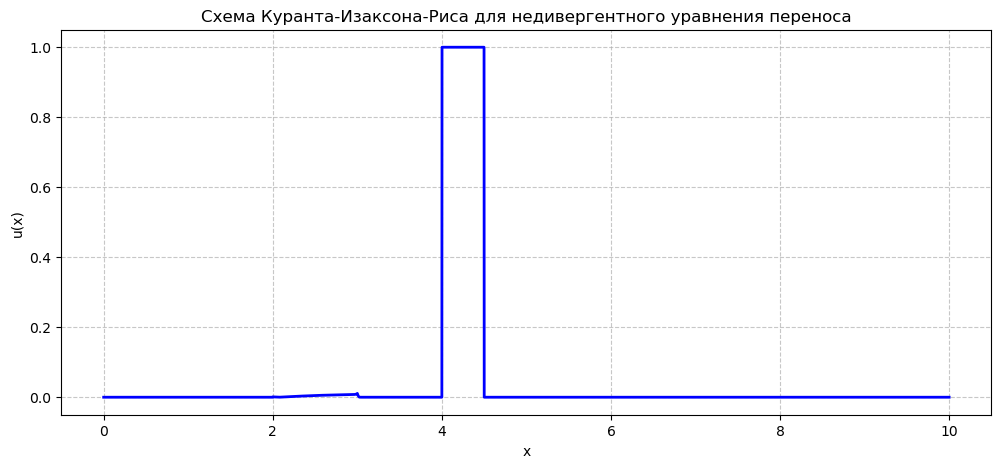

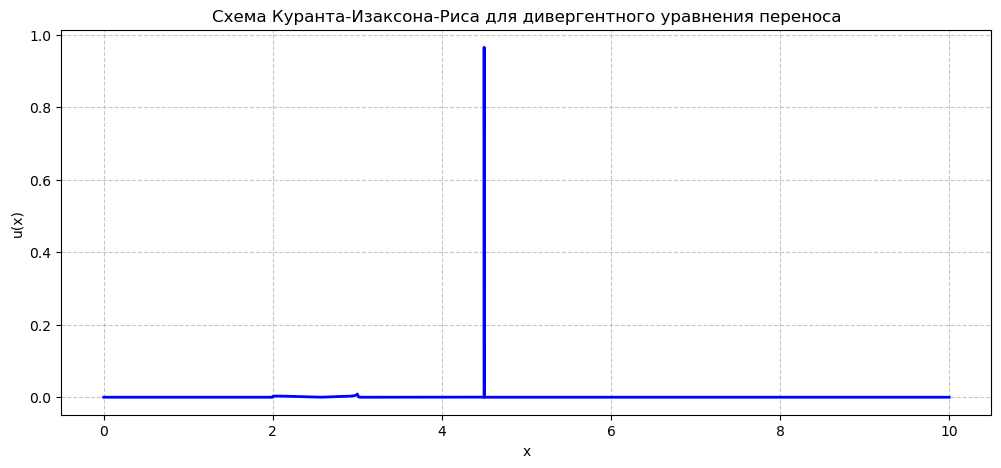

In [250]:
x_CIR_ndivergent, u_CIR_ndivergent = CIR_ndivergent(rectangle, x_start, x_end, t_start, t_end, h)
plot_difference(x_CIR_ndivergent, u_CIR_ndivergent, accurate_solution_rectangle(x_CIR_ndivergent, L/2, L, t_end), "Схема Куранта-Изаксона-Риса для недивергентного уравнения переноса")

x_CIR_divergent, u_CIR_divergent = CIR_divergent(rectangle, x_start, x_end, t_start, t_end, h)
plot_difference(x_CIR_divergent, u_CIR_divergent, accurate_solution_rectangle(x_CIR_divergent, L/2, L, t_end), "Схема Куранта-Изаксона-Риса для дивергентного уравнения переноса")

## 4.3 Cхема Лакса-Вендроффа

Схема Лакса-Вендроффа (или схема предиктор-корректор) для линейных уравнений с переменными коэффициентами становится более сложной, в отличие от случая постоянных коэффициентов. Для ее построения необходимо ввести полуцелые точки (точки с дробными индексами). На первом этапе (предиктора) значения в полуцелых точках вычисляются по следующей схеме — обобщению на  квазилинейный случай схемы Лакса:

Для недивергентного уравнения переноса имеем:

$$\frac{u^{n+1/2}_{m+1/2} - 0.5\left( u^{n}_{m+1} + u^{n}_{m}\right)}{\tau} + u^n_{m} \frac{ u^n_{m+1} - u^n_{m}}{2h} = 0$$

$$\frac{u^{n+1/2}_{m-1/2} - 0.5\left( u^{n}_{m} + u^{n}_{m-1}\right)}{\tau} + u^n_{m} \frac{u^n_{m} - u^n_{m-1}}{2h} = 0$$

На втором этапе (корректор) используется схема "чехарда":

$$\frac{u^{n+1}_{m} - u^{n}_{m}}{\tau} + u^n_{m} \frac{u^{n+1/2}_{m+1/2} - u^{n+1/2}_{m-1/2}}{h} = 0$$

В случае дивергентного уравнения переноса:
$$\frac{u^{n+1/2}_{m+1/2} - 0.5\left( u^{n}_{m+1} + u^{n}_{m}\right)}{\tau} + \frac{\left( u^n_{m+1} \right)^2 - \left(u^n_{m}\right)^2}{2 \cdot 2h} = 0$$

$$\frac{u^{n+1/2}_{m-1/2} - 0.5\left( u^{n}_{m} + u^{n}_{m-1}\right)}{\tau} + \frac{\left( u^n_{m} \right)^2 - \left(u^n_{m-1}\right)^2}{2 \cdot 2h} = 0$$

На втором этапе (корректор) используется схема "чехарда":

$$\frac{u^{n+1}_{m} - u^{n}_{m}}{\tau} + \frac{\left( u^{n+1/2}_{m+1/2} \right)^2 - \left(u^{n+1/2}_{m-1/2}\right)^2}{2h} = 0$$

Порядок аппроксимации: $ O\left( \tau^2 + h^2\right)$

Схема является условно устойчивой: $$ \frac{\tau}{h} \cdot \max_{m}|u^{n}_{m}| \le 1 $$


Реализация схемы Лакса-Вендроффа для недивергентного уравнения переноса:

In [251]:
def Lax_Wendroff_ndivergent(u_0, x_start, x_end, t_start, t_end, h):
    x = np.arange(x_start, x_end + h, h)
    u = []
    for i in x:
        u.append(u_0(i, height, L))

    u_new = u.copy()
    t_cur = t_start
    CFL = 0.9
    u_max = max(abs(elem) for elem in u)
    tau =  CFL * h / u_max

    while t_cur < t_end:
        # Определяем шаг по времени tau на основе условия Куранта
        u_max = max(abs(elem) for elem in u)
        while (tau * u_max / h > 1): 
            tau *= CFL
            
        for i in range(1, len(x) - 1):
            u_half_up = (u[i+1] + u[i])/2 - (tau / (2 * h)) * u[i] * (u[i+1] - u[i])
            u_half_down = (u[i] + u[i-1])/2 - (tau / (2 * h)) * u[i] * (u[i] - u[i-1])
            u_new[i] = u[i] - (tau / h) * u[i] * (u_half_up - u_half_down)

        t_cur += tau
        u = u_new.copy()
    return x, u

Реализация схемы Лакса-Вендроффа для дивергентного уравнения переноса:

In [252]:
def Lax_Wendroff_divergent(u_0, x_start, x_end, t_start, t_end, h):
    x = np.arange(x_start, x_end + h, h)
    u = []
    for i in x:
        u.append(u_0(i, height, L))

    u_new = u.copy()
    t_cur = t_start
    CFL = 0.9
    u_max = max(abs(elem) for elem in u)
    tau =  CFL * h / u_max
    while t_cur < t_end:
        # Определяем шаг по времени tau на основе условия Куранта
        u_max = max(abs(elem) for elem in u)
        while (tau * u_max / h > 1): 
            tau *= CFL

        for i in range(1, len(x) - 1):
            # Предиктор
            u_half_up = (u[i+1] + u[i])/2 - (tau / (4 * h)) * ((u[i+1])**2 - (u[i])**2)
            u_half_down = (u[i] + u[i-1])/2 - (tau / (4 * h)) * ((u[i])**2 - (u[i-1])**2)
            # Корректор
            u_new[i] = u[i] - (tau / (2*h)) * (u_half_up**2 - u_half_down**2)

        t_cur += tau
        u = u_new.copy()
    return x, u

Строим графики:

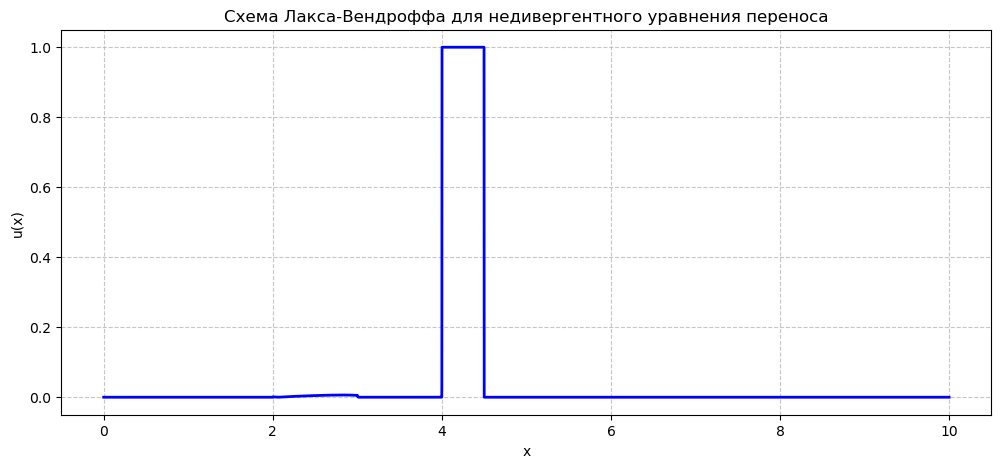

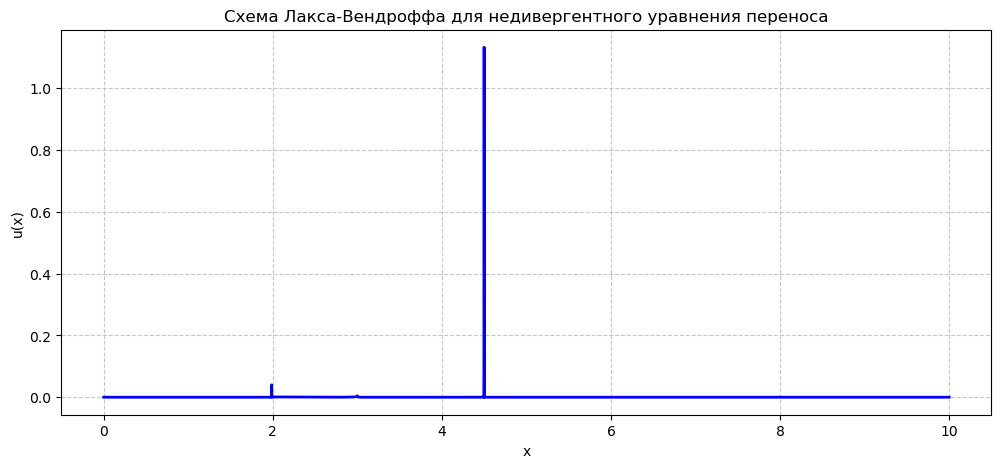

In [253]:
x_Lax_Wendroff_ndivergent, u_Lax_Wendroff_ndivergent = Lax_Wendroff_ndivergent(rectangle, x_start, x_end, t_start, t_end, h)
plot_difference(x_Lax_Wendroff_ndivergent, u_Lax_Wendroff_ndivergent, accurate_solution_rectangle(x_Lax_Wendroff_ndivergent, L/2, L, t_end), "Схема Лакса-Вендроффа для недивергентного уравнения переноса")

x_Lax_Wendroff_divergent, u_Lax_Wendroff_divergent = Lax_Wendroff_divergent(rectangle, x_start, x_end, t_start, t_end, h)
plot_difference(x_Lax_Wendroff_divergent, u_Lax_Wendroff_divergent, accurate_solution_rectangle(x_Lax_Wendroff_divergent, L/2, L, t_end), "Схема Лакса-Вендроффа для недивергентного уравнения переноса")

## 4.4 Cхема Уорминга-Кутлера-Ломакса

Cхема Уорминга-Кутлера-Ломакса реализуется в 3 этапа: предиктор, корректор, стабилизация

Для недивергентного уравнения переноса имеем:

1-й этап (предиктор):
$$
\frac{u_{m+1}^{n+1/3} - u_{m+1}^n}{2\tau/3} + u_{m+1}^{n}\frac{u_{m+2}^n - u_{m+1}^n}{h} = 0,
$$

$$
\frac{u_{m}^{n+1/3} - u_{m}^n}{2\tau/3} + u_{m}^{n}\frac{u_{m+1}^n - u_{m}^n}{h} = 0,
$$

$$
\frac{u_{m-1}^{n+1/3} - u_{m-1}^n}{2\tau/3} + u_{m-1}^{n}\frac{u_{m}^n - u_{m-1}^n}{h} = 0,
$$

$$
\frac{u_{m-2}^{n+1/3} - u_{m-2}^n}{2\tau/3} + u_{m-2}^{n}\frac{u_{m-1}^n - u_{m-2}^n}{h} = 0,
$$


2-й этап (корректор):

$$
\frac{u_{m+1}^{n+2/3} - 0.5\left(u_{m+1}^n + u_{m+1}^{n+1/3}\right)}{2\tau/3} + u_{m+1}^{n+1/3}\frac{ u_{m+1}^{n+1/3} - u_{m}^{n+1/3} }{2h} = 0.
$$

$$
\frac{u_{m-1}^{n+2/3} - 0.5\left(u_{m-1}^n + u_{m-1}^{n+1/3}\right)}{2\tau/3} + u_{m-1}^{n+1/3}\frac{ u_{m-1}^{n+1/3} - u_{m-2}^{n+1/3} }{2h} = 0.
$$

3-й этап (стабилизация):
$$
\frac{u_{m}^{n+1} - u_m^n}{\tau} + \frac{3}{8} u_{m}^{n} \frac{ u_{m+1}^{n+2/3} - u_{m-1}^{n+2/3}}{h} + u_{m}^{n} \frac{-2 u_{m+2}^n\ + 7 u_{m+1}^n - 7u_{m-1}^n + 2 u_{m-1}^n}{24h} + 
$$

$$
 + \frac{\omega}{24}\left(u_{m+2}^n - 4u_{m+1}^n + 6u_m^n - 4u_{m-1}^n + u_{m-2}^n\right) = 0, \quad \omega = const.
$$

Последнее слагаемое в разностной формуле, описывающей третий шаг схемы, является конечно-разностной аппроксимацией слагаемого с четвертой производной $ u_{xxxx} \left(x_1 – x_2 \right)^4$,  дополнительно введенного для
обеспечения устойчивости схемы.

Для дивергентного уравнения переноса имеем:

1-й этап (предиктор):
$$
\frac{u_{m+1}^{n+1/3} - u_{m+1}^n}{2\tau/3} + \frac{ \left(u_{m+2}^n \right)^2 - \left( u_{m+1}^n \right)^2}{2h} = 0,
$$
$$
\frac{u_{m}^{n+1/3} - u_m^n}{2\tau/3} + \frac{ \left(u_{m+1}^n \right)^2 - \left( u_{m}^n \right)^2}{2h} = 0,
$$
$$
\frac{u_{m-1}^{n+1/3} - u_{m-1}^n}{2\tau/3} + \frac{\left(u_{m}^n \right)^2 - \left( u_{m-1}^n \right)^2}{2h} = 0.
$$

$$
\frac{u_{m-2}^{n+1/3} - u_{m-2}^n}{2\tau/3} + \frac{\left(u_{m-1}^n \right)^2 - \left( u_{m-2}^n \right)^2}{2h} = 0.
$$

2-й этап (корректор):

$$
\frac{u_{m+1}^{n+2/3} - 0.5\left(u_{m+1}^n + u_{m+1}^{n+1/3}\right)}{2\tau/3} + \frac{\left( u_{m+1}^{n+1/3} \right)^2 - \left( u_{m}^{n+1/3} \right)^2}{2 \cdot 2h} = 0.
$$

$$
\frac{u_{m-1}^{n+2/3} - 0.5\left(u_{m-1}^n + u_{m-1}^{n+1/3}\right)}{2\tau/3} + \frac{\left( u_{m-1}^{n+1/3} \right)^2 - \left( u_{m-2}^{n+1/3} \right)^2}{2 \cdot 2h} = 0,
$$

3-й этап (стабилизация):
$$
\frac{u_{m}^{n+1} - u_m^n}{\tau} + \frac{3}{8} \frac{\left( u_{m+1}^{n+2/3} \right)^2 - \left( u_{m-1}^{n+2/3} \right)^2}{2 \cdot h} + \frac{-2\left(u_{m+2}^n\right)^2 + 7\left( u_{m+1}^n\right)^2 - 7\left(u_{m-1}^n\right)^2 + 2\left(u_{m-1}^n\right)^2}{2 \cdot 24h} + $$
$$
 + \frac{\omega}{24}\left(u_{m+2}^n - 4u_{m+1}^n + 6u_m^n - 4u_{m-1}^n + u_{m-2}^n\right) = 0, \quad \omega = const.
$$


Порядок аппроксимации: $ O\left( \tau^3 + h^3\right)$

Схема является условно устойчивой: $$ r \le 1 \qquad \text{и} \qquad 4r^2 - r^4 < \omega < 3, \text{ где }r = \frac{\tau}{h} \cdot \max_{m}|u^{n}_{m}|$$

Реализация схемы Уорминга-Кутлера-Ломакса для недивергентного уравнения переноса:

In [254]:
def WKL_ndivergent(u_0, x_start, x_end, t_start, t_end, h):
    x = np.arange(x_start, x_end + h, h)
    u = []
    for i in x:
        u.append(u_0(i, height, L))

    u_new = u.copy()
    t_cur = t_start
    omega = 2.7 # Взято, исходя из того, что r = 0.9
    u_max = max(abs(elem) for elem in u)
    tau = h
    r = tau * u_max / h
    while t_cur < t_end:
        # Определяем шаг по времени tau на основе условия Куранта
        u_max = max(abs(elem) for elem in u)
        while (not (4 * r**2 - r**4 < omega and tau * u_max / h < 1)):
            tau *= 0.9
            r = tau * u_max / h

        for i in range(2, len(x) - 2):
            # Предиктор
            u_pred_p_one = u[i+1] - ((2 * tau) / (3 * h)) * u[i+1] * (u[i+2] - u[i+1])
            u_pred_zero  = u[i] - ((2 * tau) / (3 * h)) * u[i] * (u[i+1] - u[i])
            u_pred_m_one = u[i-1] - ((2 * tau) / (3 * h)) * u[i-1] * (u[i] - u[i-1])
            u_pred_m_two = u[i-2] - ((2 * tau) / (3 * h)) * u[i-2] * (u[i-1] - u[i-2])
            # Корректор
            u_corr_up = 0.5 * (u[i+1] + u_pred_p_one) - (tau / (3 * h)) * u_pred_p_one * (u_pred_p_one -  u_pred_zero)
            u_corr_down = 0.5 * (u[i-1] + u_pred_m_one) - (tau / (3 * h)) * u_pred_m_one * (u_pred_m_one -  u_pred_m_two)
            # Стабилизация
            u_new[i] = u[i] - ((3 * tau) / (8 * h)) * u[i] * (u_corr_up - u_corr_down) - (tau / (24 * h)) * u[i] * (-2 * u[i+2] + 7 * u[i+1] - 7 * u[i-1] + 2 * u[i-2]) - (omega / 24) * (u[i+2] - 4 * u[i+1] + 6 * u[i] -4 * u[i-1] + u[i-2])
    
        t_cur += tau
        u = u_new.copy()
    return x, u

Реализация схемы Уорминга-Кутлера-Ломакса для дивергентного уравнения переноса:

In [255]:
def WKL_divergent(u_0, x_start, x_end, t_start, t_end, h):
    x = np.arange(x_start, x_end + h, h)
    u = []
    for i in x:
        u.append(u_0(i, height, L))

    u_new = u.copy()
    t_cur = t_start
    omega = 2.7 # Взято, исходя из того, что r = 0.9
    u_max = max(abs(elem) for elem in u)
    tau = h
    r = tau * u_max / h
    while t_cur < t_end:
        # Определяем шаг по времени tau на основе условия Куранта
        u_max = max(abs(elem) for elem in u)
        while (not (4 * r**2 - r**4 < omega and tau * u_max / h < 1)):
            tau *= 0.9
            r = tau * u_max / h

        for i in range(2, len(x) - 2):
            # Предиктор
            u_pred_p_one = u[i+1] - (tau / (3 * h)) * ((u[i+2])**2 - (u[i+1])**2)
            u_pred_zero = u[i] - (tau / (3 * h)) * ((u[i+1])**2 - (u[i])**2)
            u_pred_m_one = u[i-1] - (tau / (3 * h)) * ((u[i])**2 - (u[i-1])**2)
            u_pred_m_two = u[i-2] - (tau / (3 * h)) * ((u[i-1])**2 - (u[i-2])**2)
            # Корректор
            u_corr_up = 0.5 * (u[i+1] + u_pred_p_one) - (tau / (6 * h)) * (u_pred_p_one**2 -  u_pred_zero**2)
            u_corr_down = 0.5 * (u[i-1] + u_pred_m_one) - (tau / (6 * h)) * (u_pred_m_one**2 -  u_pred_m_two**2)
            # Стабилизация
            u_new[i] = u[i] - ((3 * tau) / (16 * h)) * (u_corr_up**2 - u_corr_down**2) - (tau / (48 * h)) * (-2 * (u[i+2])**2 + 7 * (u[i+1])**2 - 7 * (u[i-1])**2 + 2 * (u[i-2])**2) - (omega / 24) * (u[i+2] - 4 * u[i+1] + 6 * u[i] -4 * u[i-1] + u[i-2])

        t_cur += tau
        u = u_new.copy()
    return x, u

Строим графики:

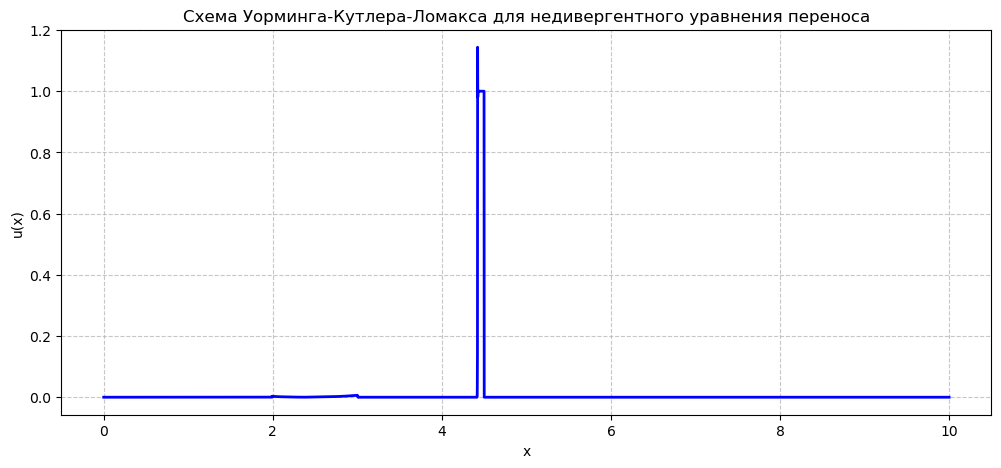

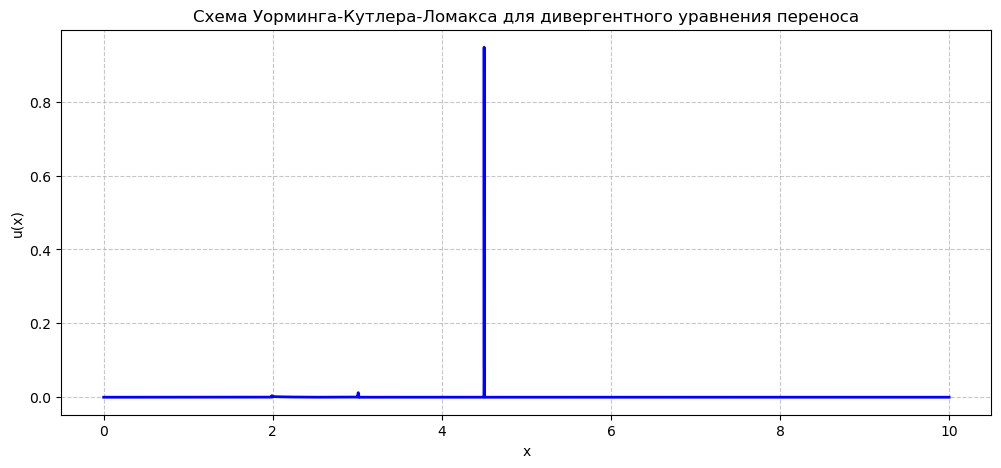

In [256]:
x_WKL_ndivergent, u_WKL_ndivergent = WKL_ndivergent(rectangle, x_start, x_end, t_start, t_end, h)
plot_difference(x_WKL_ndivergent, u_WKL_ndivergent, accurate_solution_rectangle(x_WKL_ndivergent, L/2, L, t_end), "Схема Уорминга-Кутлера-Ломакса для недивергентного уравнения переноса")

x_WKL_divergent, u_WKL_divergent = WKL_divergent(rectangle, x_start, x_end, t_start, t_end, h)
plot_difference(x_WKL_divergent, u_WKL_divergent, accurate_solution_rectangle(x_WKL_divergent, L/2, L, t_end), "Схема Уорминга-Кутлера-Ломакса для дивергентного уравнения переноса")

# 4. Исследование треугольного профиля

## 4.1 Схема Лакса

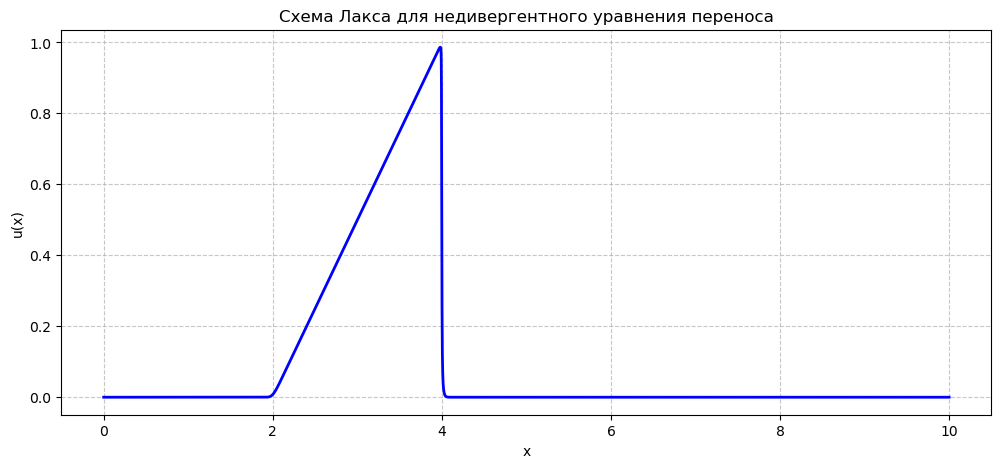

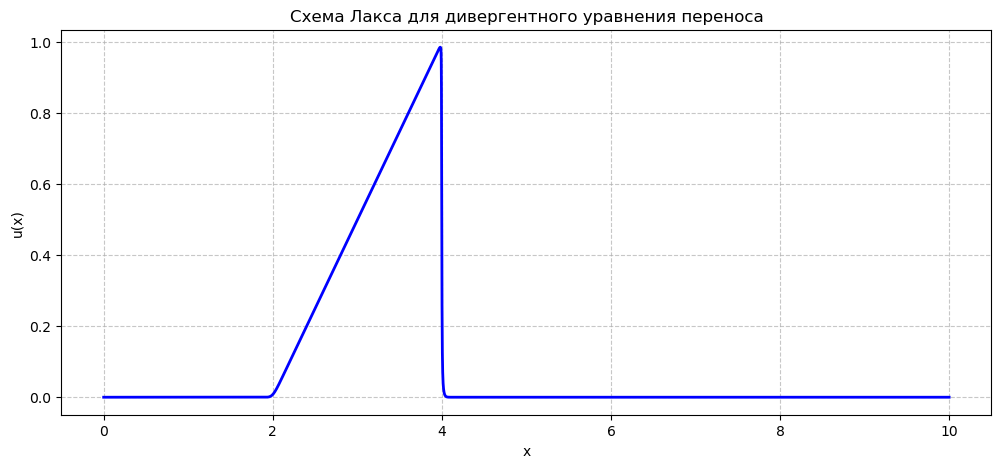

In [257]:
x_Lax_ndivergent, u_Lax_ndivergent = Lax_ndivergent(triangle, x_start, x_end, t_start, t_end, h)
plot_graph(x_Lax_ndivergent, u_Lax_ndivergent, "Схема Лакса для недивергентного уравнения переноса")

x_Lax_divergent, u_Lax_divergent = Lax_divergent(triangle, x_start, x_end, t_start, t_end, h)
plot_graph(x_Lax_divergent, u_Lax_divergent, "Схема Лакса для дивергентного уравнения переноса")

## 4.2 Схема Куранта-Изаксона-Риса

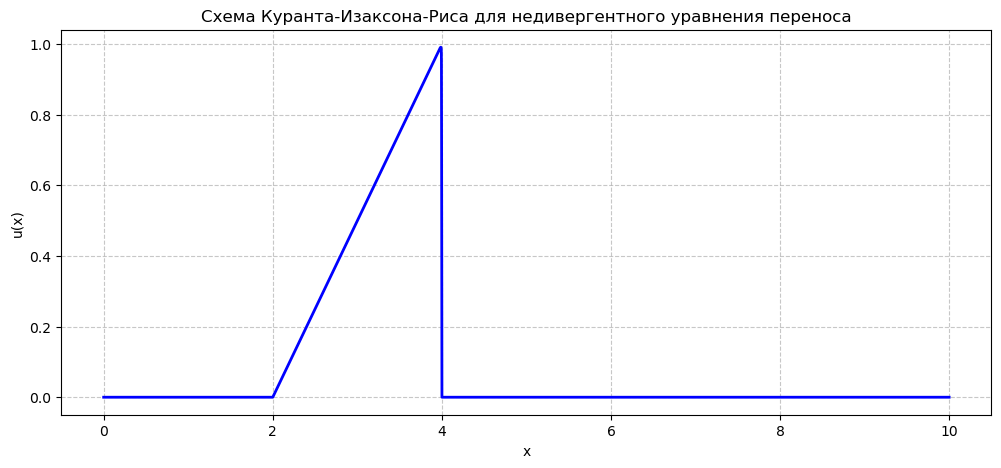

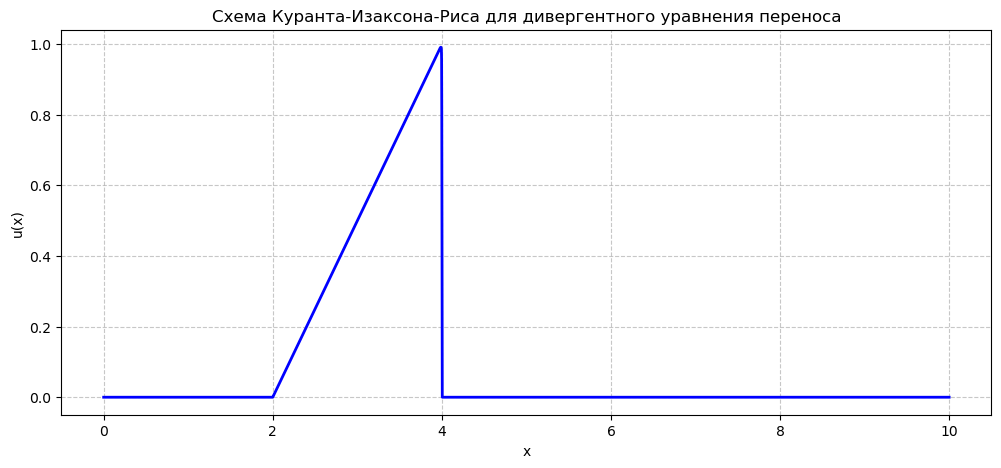

In [258]:
x_CIR_ndivergent, u_CIR_ndivergent = CIR_ndivergent(triangle, x_start, x_end, t_start, t_end, h)
plot_graph(x_CIR_ndivergent, u_CIR_ndivergent, "Схема Куранта-Изаксона-Риса для недивергентного уравнения переноса")

x_CIR_divergent, u_CIR_divergent = CIR_divergent(triangle, x_start, x_end, t_start, t_end, h)
plot_graph(x_CIR_divergent, u_CIR_divergent, "Схема Куранта-Изаксона-Риса для дивергентного уравнения переноса")

## 4.3 Схема Лакса-Вендроффа

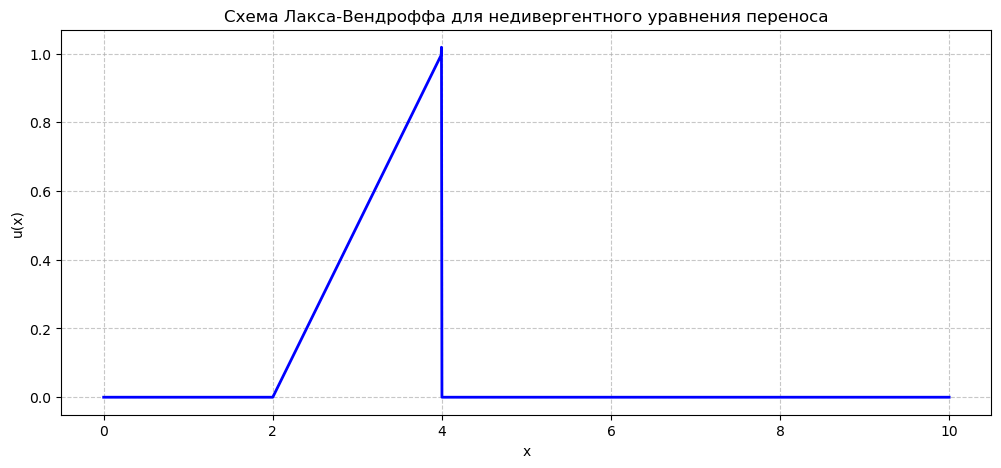

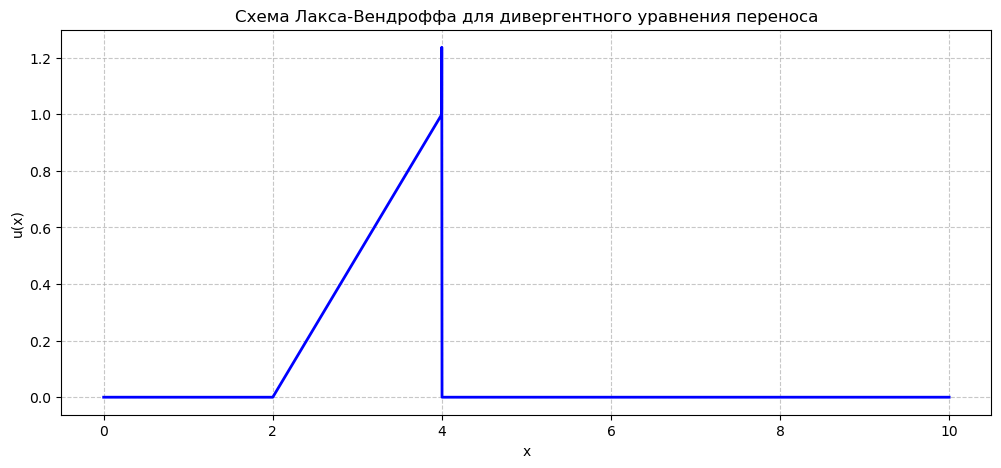

In [259]:
x_Lax_Wendroff_ndivergent, u_Lax_Wendroff_ndivergent = Lax_Wendroff_ndivergent(triangle, x_start, x_end, t_start, t_end, h)
plot_graph(x_Lax_Wendroff_ndivergent, u_Lax_Wendroff_ndivergent, "Схема Лакса-Вендроффа для недивергентного уравнения переноса")

x_Lax_Wendroff_divergent, u_Lax_Wendroff_divergent = Lax_Wendroff_divergent(triangle, x_start, x_end, t_start, t_end, h)
plot_graph(x_Lax_Wendroff_divergent, u_Lax_Wendroff_divergent, "Схема Лакса-Вендроффа для дивергентного уравнения переноса")

## 4.4 Схема Уорминга-Кутлера-Ломакса

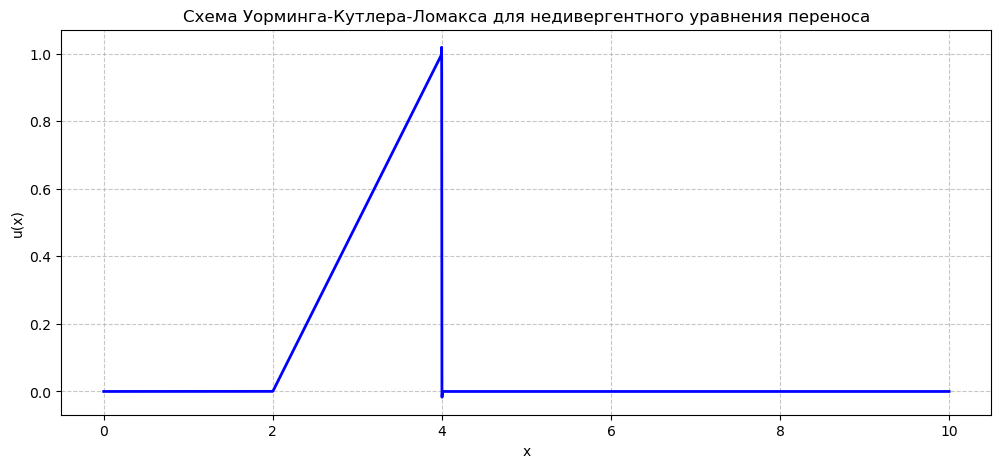

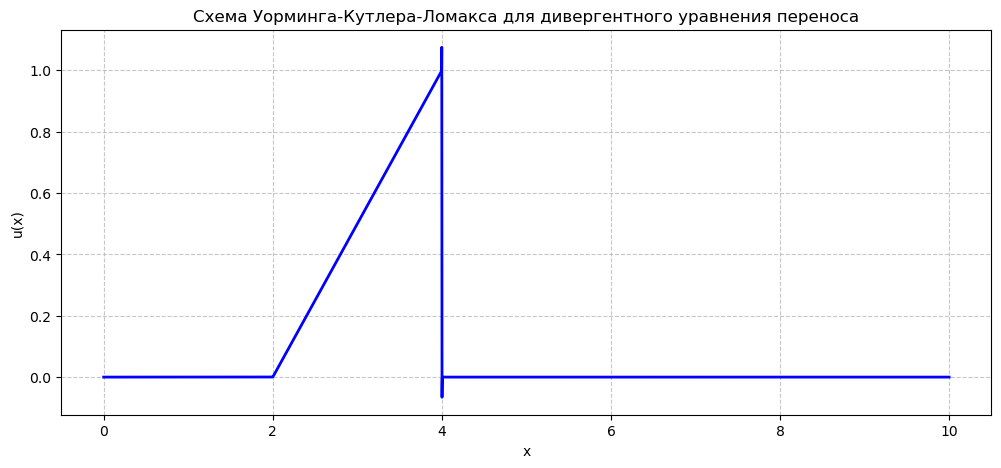

In [260]:
x_WKL_ndivergent, u_WKL_ndivergent = WKL_ndivergent(triangle, x_start, x_end, t_start, t_end, h)
plot_graph(x_WKL_ndivergent, u_WKL_ndivergent, "Схема Уорминга-Кутлера-Ломакса для недивергентного уравнения переноса")

x_WKL_divergent, u_WKL_divergent = WKL_divergent(triangle, x_start, x_end, t_start, t_end, h)
plot_graph(x_WKL_divergent, u_WKL_divergent, "Схема Уорминга-Кутлера-Ломакса для дивергентного уравнения переноса")